In [1]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import xtrack as xt
import xobjects as xo
import xpart as xp

import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm








# beta_rel = 0.305
beta_rel = 0.106

# gamma = 1.050
gamma = 1.006


I=0.4
L = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 0.01 # <E> [eV] = kb*T
T_l =  0.001 # <E> [eV]
B = 0.060 # T for LEIR
B_ratio=1e-10
Z=1


c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



length = 182.43280000000 #m
T = length/(c*beta_rel)
ms_per_turn = 1000*T





beta_x=10 
beta_y=4
emittance=10*1e-6

arc=dtk.LinearTransferMatrix(Q_x=5.38518956965, Q_y=5.36921653748,
                            beta_x_0=beta_x, beta_x_1=beta_x,
                            beta_y_0=beta_y,  beta_y_1=beta_y,
                            alpha_x_0=0,   alpha_x_1=0,
                            alpha_y_0=0,   alpha_y_1=0,
                            disp_x_0=0,disp_x_1=0,
                            disp_y_0=0,    disp_y_1=0,
                            beta_s=1*1e40,
                            Q_s=0,
                            chroma_x=0.0, chroma_y=0
                                           
                 )




num_particles=100

#x=np.random.normal(0,np.sqrt(5*emittance) ,num_particles),
#px=np.random.normal(0, np.sqrt(emittance/5), num_particles),
#x=np.linspace(1*1e-3, 20*1e-3, num_particles),
#px=np.random.uniform(0, 0, num_particles),

dtk_particle = dtk.TestParticles(
        
        mass0=mass0,
        p0c=p0c,
        x=np.linspace(1e-3,20*1e-3,num_particles),
        px=np.random.normal(0, 0*np.sqrt(emittance/beta_x), num_particles),
        y=0,
        py=0,
        delta=0,
        zeta=0)

dtk_particle_copy_old=dtk_particle.copy()


dtk_cooler = dtk.elements.ElectronCooler(I=I,L=L,r_beam=r_beam,
                                         T_perp=T_perp,T_l=T_l,
                                         B=B,Z=Z,B_ratio=B_ratio,Neutralisation=1)

       


num_turns=int(6e5)


x=[]
px=[]
action = []
force = []



for i in tqdm(range(num_turns)):
    x.append(dtk_particle.x)
    px.append(dtk_particle.px)
    
    action_temp = 0.5*(dtk_particle.x**2/beta_x + beta_x*dtk_particle.px**2) #Joule sec
    action.append(action_temp)
    force.append(dtk_cooler.force(dtk_particle))
    
    arc.track(dtk_particle)
    dtk_cooler.track(dtk_particle)
    
action_arr=np.stack(action, axis=0)

goal_actions=5e-8

arrays = []
for i in range(num_particles):
    column = action_arr[:,i]
    indices = action_arr<goal_actions

    first_index = np.argmax(column<goal_actions)
    if first_index==0:
        turns_to_reach_goal=np.empty(num_turns); turns_to_reach_goal.fill(1e7)
    if first_index!=0:   
        turns_to_reach_goal = first_index - np.arange(num_turns)
    turns_to_reach_goal[turns_to_reach_goal<0] = 0

    arrays.append(turns_to_reach_goal)

turns_to_reach_goal_2d = np.stack(arrays, axis=1)

ms_to_reach_goal_2d=turns_to_reach_goal_2d*ms_per_turn

x = np.array(x)
px = np.array(px)
action = np.array(action)
force = np.array(force)


ms_to_reach_final_goal=ms_to_reach_goal_2d[0,:]




  6%|▌         | 33002/600000 [00:14<03:43, 2538.78it/s]

In [2]:
action_norm=action/np.min(action)

plt.figure()
plt.scatter(x, px, c=action, cmap='jet')
plt.colorbar().set_label("Action")
plt.xlabel('x [m]')
plt.ylabel('px [rad]')
plt.title('Normalised action in phase space')
plt.show()

KeyboardInterrupt: 

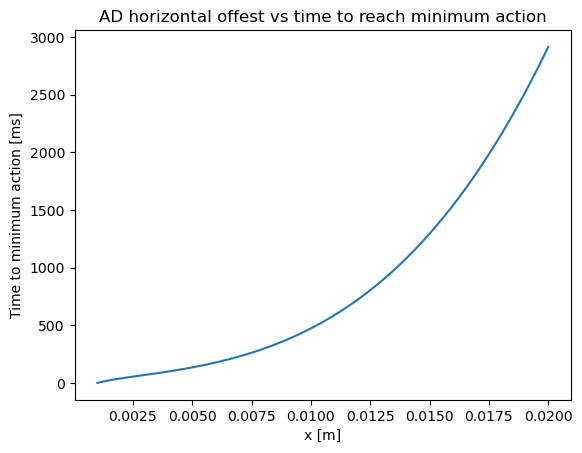

In [2]:
plt.figure()
plt.plot(x[0,:],ms_to_reach_final_goal)
plt.xlabel('x [m]')
plt.ylabel('Time to minimum action [ms]')
plt.title('AD horizontal offest vs time to reach minimum action')
plt.show()

In [3]:
np.save("plot_data/AD_x_sc.npy", x[0,:])
np.save("plot_data/AD_ms_sc.npy", ms_to_reach_final_goal)

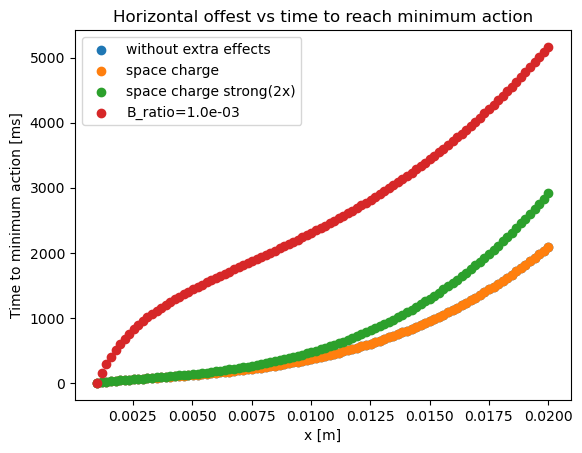